# Tutorial 2: Modelos "Cómo"

# Configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#@title Configuración de figura

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Funciones de graficado

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times, n_bins = None):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    if n_bins:
      pass
    else:
      n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

---
# Sección 1: La neurona lineal de integración y disparo

¿Cómo se activa una neurona?

Modelo simple: modelo "integra y dispara" lineal. Cada paso, la neurona "integra" una corriente I tal que:

\begin{align}
  dV_m = {\alpha}I
\end{align}

Una vez que $V_m$ alcanza un valor de **umbral**, se produce un pico, $V_m$ se restablece a un **valor de reset** (que valor es?) y el proceso continúa.

Aquí, tomaremos los potenciales inicial y de umbral como $0$ y $1$, respectivamente.

Entonces, por ejemplo, si $\alpha I=0.1$ es constante, es decir, la corriente de entrada es constante, entonces $dV_m=0.1$, y en cada paso de tiempo el potencial de membrana $V_m$ aumenta en $0.1$. hasta que después de $(1-0)/0.1 = 10$ pasos de tiempo alcanza el umbral y se restablece a $V_m=0$, y así sucesivamente.

### **Estamos describiendo el potencial de membrana con un único número ¿eso es correcto?**

## **Entrada de corriente**

¿Cómo debemos modelamos el comportamiento de disparo de la(s) neurona(s) presináptica(s) que proporciona(n) las entradas a nuestra neurona modelo?

Supondremos que la corriente de entrada $I$ durante un período de tiempo se debe a contribuciones iguales de un número entero no negativo ($\ge 0$) de disparos que llegan en ese período de tiempo.

Dado que no hay otra información sobre las neuronas de entrada, supondremos que la distribución tiene una media (es decir, tasa media o número de picos recibidos por paso de tiempo) y que los eventos de picos de la(s) neurona(s) de entrada son independientes en el tiempo.
###**¿Son estas suposiciones razonables en el contexto de las neuronas reales?¿Que implicaría que los disparos de las neuronas _NO_ sean independientes?**

Una distribución adecuada dadas estas suposiciones es la distribución de Poisson, que usaremos para modelar $I$:

\begin{align}
  I \sim \mathrm{Poisson}(\lambda)
\end{align}

Recordatorio de distribución de Poisson:
Probabilidad de que ocurran X eventos
\begin{align}
  p(X=x) = \frac{\lambda^x}{x!}e^{-\lambda}
\end{align}
donde $\lambda$ es la media de la distribución: la tasa promedio de picos recibidos por paso de tiempo.

## Simulación de LIF con entrada Poisson


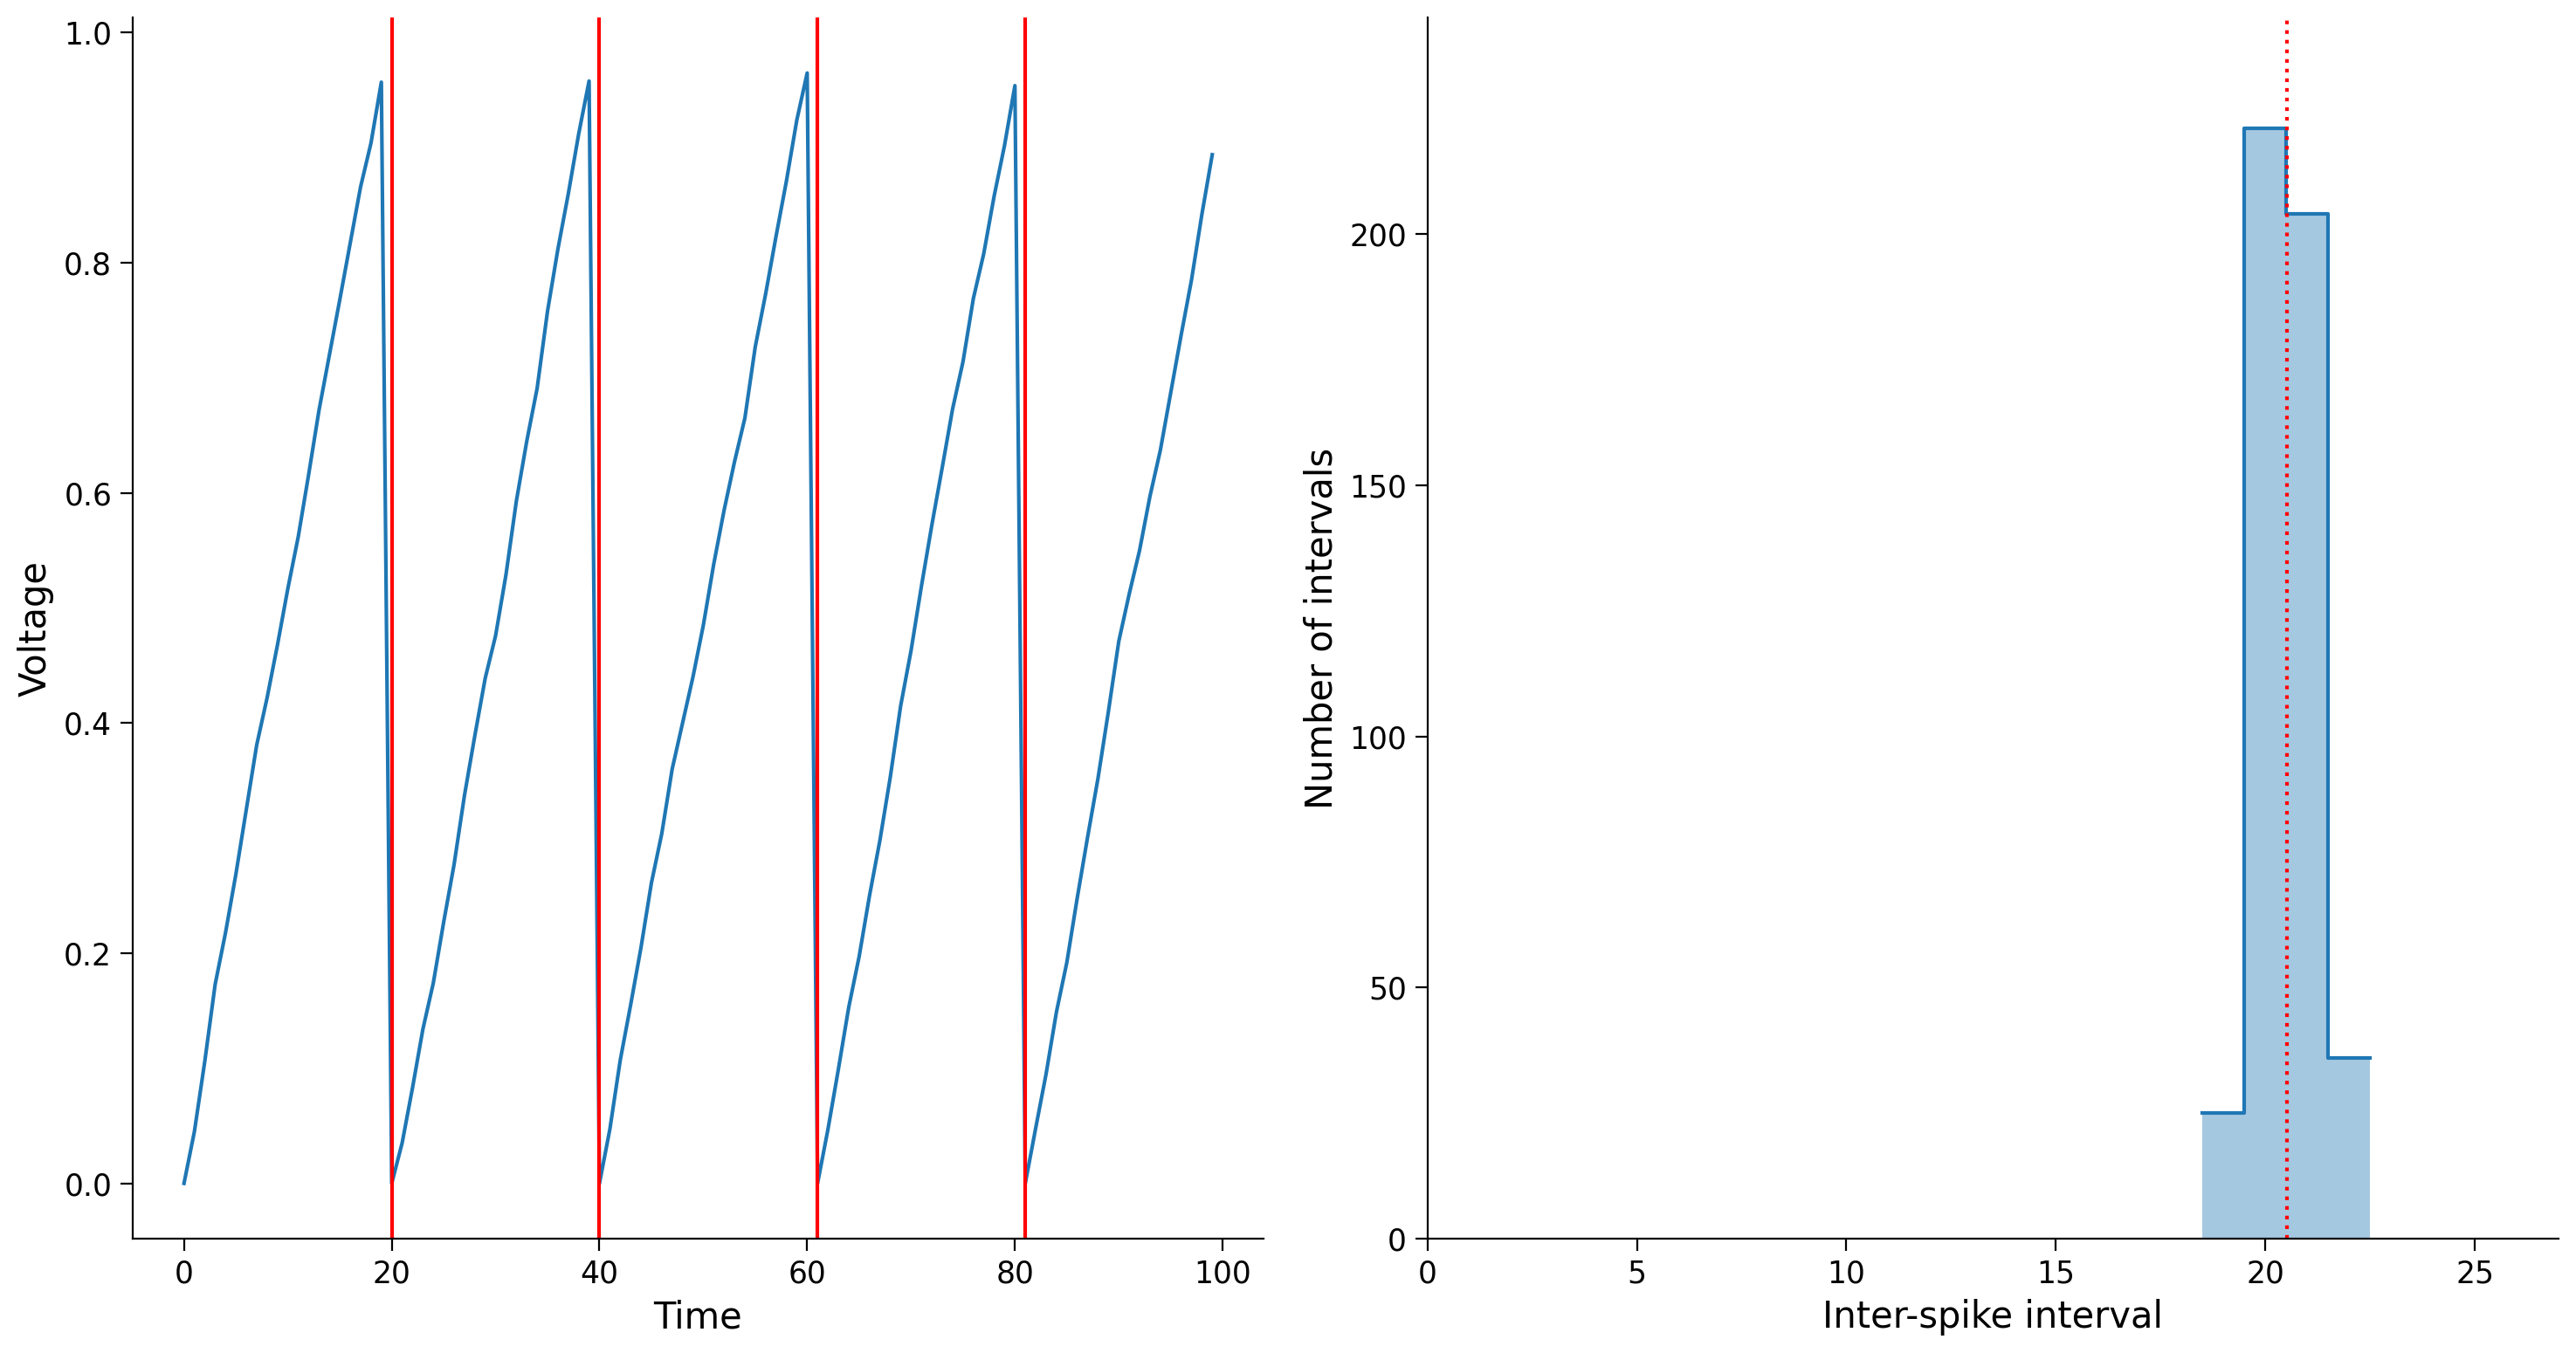

In [4]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simule una neurona lineal de integración y disparo.

  Args:
    n_steps (int): El número de pasos de tiempo para simular la actividad de la neurona.
    alpha (float): El factor de escala de entrada
    rate (int): La tasa media de picos entrantes

  """
  # Precalcular muestras de Poisson para velocidad
  exc = stats.poisson(rate).rvs(n_steps)

  # Inicializar el almacenamiento de voltaje y picos
  v = np.zeros(n_steps)
  spike_times = []

  # Loop sobre los pasos
  for i in range(1, n_steps):

    # actualizar v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # Si ocurre un pico, restablezca el voltaje y registre
    if v[i] > 1: #acá se podría cambiar el umbral
      spike_times.append(i)
      v[i] = 0 #acá se podría cambiar el reset

  return v, spike_times

# Establecer semilla aleatoria (para reproducibilidad)
np.random.seed(12)

# Neurona modelo LIF
v, spike_times = lif_neuron(alpha = 0.001, rate = 50, n_steps = 10000)

# Visualizar
# with plt.xkcd():
plot_neuron_stats(v, spike_times)

1.  ¿Cuál es el patrón de picos de este modelo?
2.   ¿Qué efecto tiene el subir o bajar alfa?
3.   ¿Qué efecto tiene subir o bajar el rate $\lambda$?
4.   ¿Se parece alguna vez la distribución de los ISIs a lo que se observó en los datos del Tutorial 1?

In [5]:
# @markdown No necesitas preocuparte por cómo funciona el código, pero sí necesitas **ejecutar la celda** para habilitar los controles deslizantes.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

---
# Sección 2: Señales inhibitorias

Nuestra neurona anterior era demasiado regular en sus disparos ¿Qué le falta a nuestra neurona modelo, dado que no se comporta como una neurona real?
---
* Ahora mismo, el potencial de membrana baja solo cuando dispara. Neuronas reales tienen la tendencia de mover su potencial al _potencial de reposo_. ¿Como podemos modelar esto?

\begin{align}
  dV_m = -{\beta}(V_m-V_0) + {\alpha}I
\end{align}

donde $V_m$ es el potencial de membrana actual y $\beta$ es algún factor de fuga.



* Las neuronas reales tienen entradas tanto excitatorias como _inhibitorias_! ¿Como podemos modelar esto?

Una opción: otra variable aleatoria de Poisson:

\begin{align}
I = I_{\mathrm{exc}} - I_{\mathrm{inh}} \\
I_{\mathrm{exc}} \sim \mathrm{Poisson}(\lambda_{\mathrm{exc}}) \\
I_{\mathrm{inh}} \sim \mathrm{Poisson}(\lambda_{\mathrm{inh}})
\end{align}

donde $\lambda_{\mathrm{exc}}$ y $\lambda_{\mathrm{inh}}$ son las tasas de pico promedio (por paso de tiempo) de las neuronas presinápticas excitatorias e inhibidoras, respectivamente.

### De donde salen $\alpha$ y $\beta$?
Es un modelo simplificado de HH!
\begin{align}
C_{m}\frac{dV_m}{dt} = -(V_m - V_0)/R_{m} + I
\end{align}

### Ejercicio de codificación 2: Calcular el $dV_m$ con señales inhibitorias

Para el segundo ejercicio, volverás a escribir el código para calcular el cambio en el voltaje $dV_m$, aunque ahora de la neurona modelo LIF descrita anteriormente. Al igual que la última vez, se te proporcionará el resto del código necesario para manejar la dinámica de las neuronas, por lo que solo necesitarás completar una definición para `dv` a continuación.


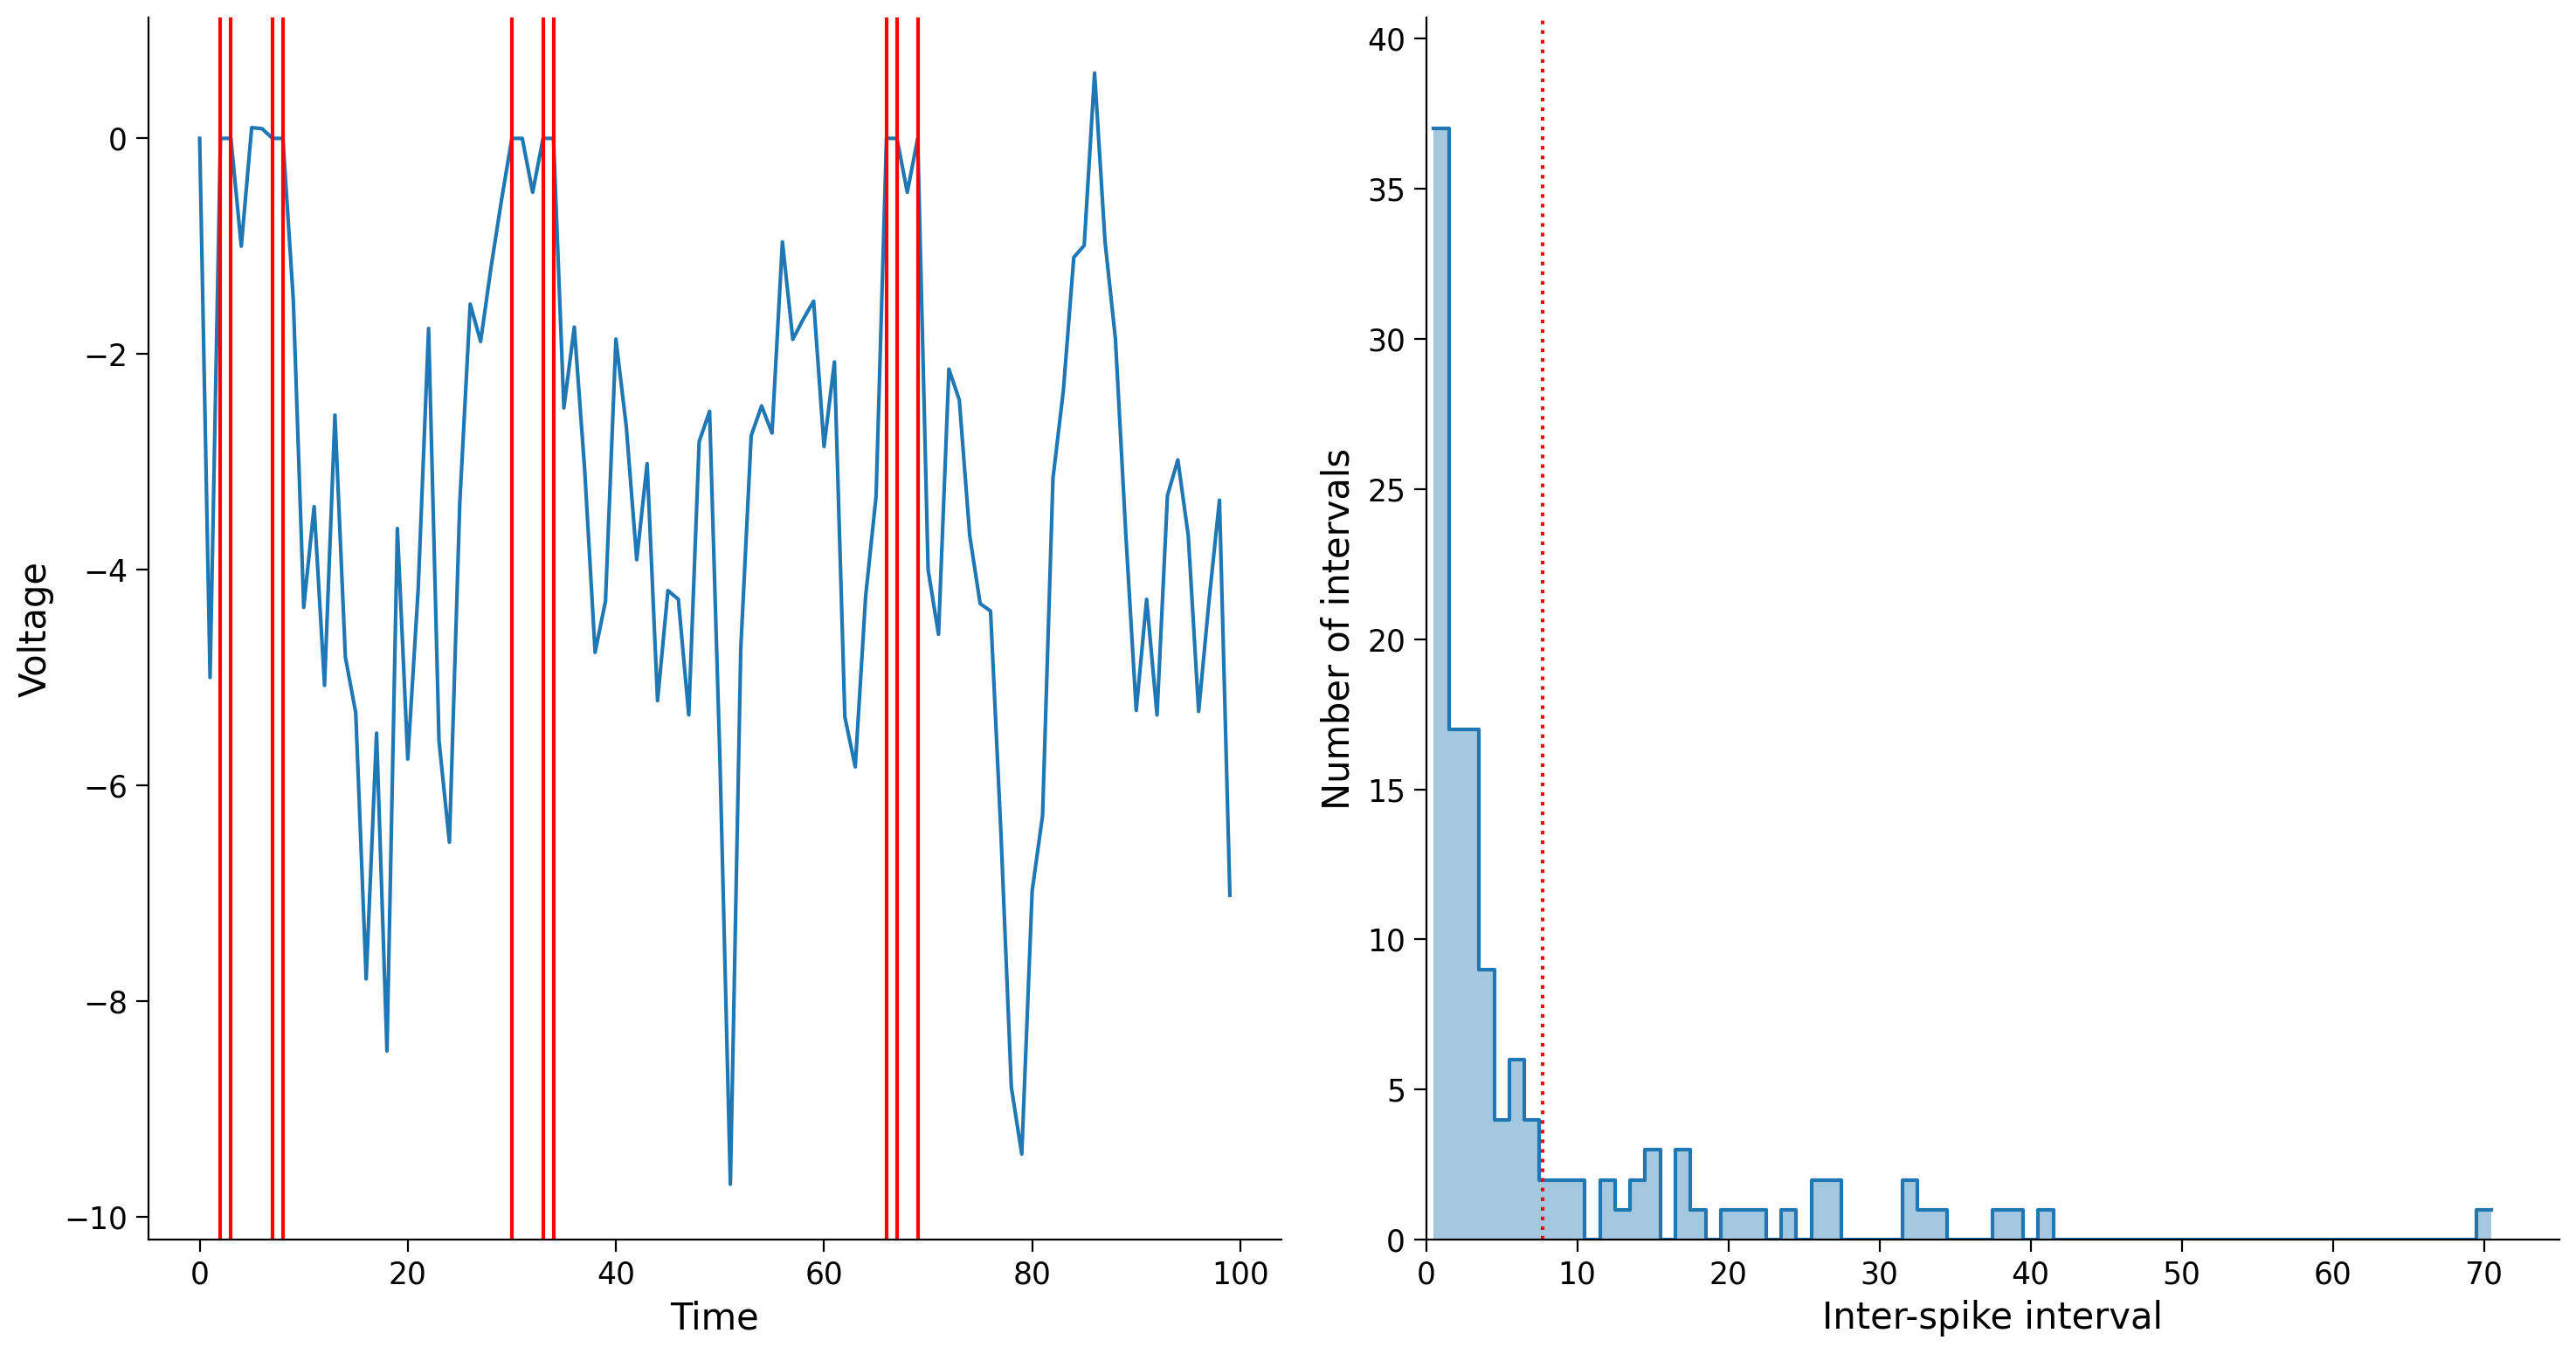

In [6]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simule una neurona simplificada de integración y disparo con
  fugas con entradas excitatorias e inhibitorias.

  Args:
    n_steps (int): El número de pasos de tiempo para simular la actividad de la neurona.
    alpha (float): El factor de escala de entrada
    beta (float): El factor de fuga del potencial de membrana
    exc_rate (int): La tasa media de los picos excitatorios entrantes
    inh_rate (int): La tasa media de los picos inhibitorios entrantes
  """

  # precalcular muestras de Poisson para velocidad
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  ################################################################################

  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i]) #Notar que está implicitamente seteado V_0 = 0

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Establecer semilla aleatoria (para reproducibilidad)
np.random.seed(12)

# Neurona modelo LIF
v, spike_times = lif_neuron_inh()

# Visualizar
plot_neuron_stats(v, spike_times)

## Demo interactiva 2: LIF + neurona inhibitoria

1.   ¿Qué efecto tiene el aumento de la tasa de excitación?
2.   ¿Qué efecto tiene el aumento de la tasa inhibitoria?
3.   ¿Qué sucede si aumentas tanto la tasa de excitación como la de inhibición?
4.   ¿Se parece alguna vez la distribución de los ISIs a lo que se observó en los datos del Tutorial 1?


In [7]:
#@title
#@markdown **Ejecuta la celda** para habilitar los controles deslizantes.
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simule una neurona simplificada de integración y disparo con
  fugas con entradas excitatorias e inhibitorias.
  Args:
    n_steps (int): El número de pasos de tiempo para simular la actividad de la neurona.
    alpha (float): El factor de escala de entrada
    beta (float): El factor de fuga del potencial de membrana
    exc_rate (int): La tasa media de los picos excitatorios entrantes
    inh_rate (int): La tasa media de los picos inhibitorios entrantes
  """
  # precalcular muestras de Poisson para velocidad
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…

# ¿Por que está piola que la ISI sea exponencial? (piensen en propiedades de distribuciones)

### Efectos de la fuga
* Se generan "ventanas de integración"
* Las ventanas son independientes entre si (entradas independientes)

# Volvamos a las diapos!